In [1]:
import pickle

# Load meta dict

with open('../../PNC/AllSubjectsMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
print(len(list(meta.keys())))

941


In [2]:
para = 'emoid'
blacklist = [180] # emoid: 180; rest: 220,233,274,284,472

subidsRest = [_id for _id in meta if para in meta[_id] and int(meta[_id][para]) not in blacklist] 

# Load timeseries

def loadSeries(prefix, para, idx):
    with open('{:}/{:}_fmri_power264/timeseries/{:}.bin'.format(prefix, para, idx), 'rb') as f:
        return pickle.load(f)

rest_ts = [loadSeries('../../PNC', para, meta[subid][para]) for subid in subidsRest]

print('Loading complete')
print(len(rest_ts))

Loading complete
678


In [142]:
# Convert to pytorch
# Split into train and test

import numpy as np
import torch

rest_ts_t = torch.from_numpy(np.stack(rest_ts)).permute(0,2,1).float()

perm = torch.randperm(rest_ts_t.shape[0])
trainIdx = perm[:600]
testIdx = perm[600:]

rest_ts_t_train = rest_ts_t[trainIdx].cuda()
rest_ts_t_test = rest_ts_t[testIdx].cuda()

print(rest_ts_t.shape)
print(rest_ts_t_train.shape)
print(rest_ts_t_test.shape)

torch.Size([678, 210, 264])
torch.Size([600, 210, 264])
torch.Size([78, 210, 264])


In [143]:
# Ages

ages = []

for _id in meta:
    if para in meta[_id] and int(meta[_id][para]) not in blacklist:
        ages.append(meta[_id]['meta']['AgeInMonths']/12)

ages = torch.tensor(ages).float()
ages_train = ages[trainIdx].cuda()
ages_test = ages[testIdx].cuda()

print(ages.shape)
print(ages_train.shape)
print(ages_test.shape)

torch.Size([678])
torch.Size([600])
torch.Size([78])


In [174]:
import torch.nn as nn
import torch.nn.functional as F

nSub = rest_ts_t.shape[0]
nRoi = rest_ts_t.shape[1]
nt = rest_ts_t.shape[2]
nHid = 2

class GAT1(nn.Module):
    def __init__(self):
        super(GAT1, self).__init__()
        self.W = nn.ParameterList([nn.Parameter(0.1*torch.eye(nt,nt).float().cuda())]
                                  +[nn.Parameter(0.1*torch.eye(nHid,nHid).float().cuda())])
        self.Z = nn.ParameterList([nn.Parameter(0.1*torch.eye(nt,nHid).float().cuda())]
                                  +[nn.Parameter(0.1*torch.eye(nHid,nHid).float().cuda())])
        
        self.fc = nn.Linear(nRoi*nHid,1).float().cuda()
        self.m = nn.Softmax(dim=2)
        
    def calcEdges(self, x, W):
        y = torch.einsum('nis,st->nit',x, W)
        e = torch.einsum('nit,njt->nij',y, x)
        return e
        
    def forward(self, x):
        nB = x.shape[0]
        for i in range(1):
            e = self.calcEdges(x, self.W[i])
            x = torch.einsum('nij,njt->nit',e,x)
            x = F.relu(torch.einsum('nit,th->nih',x,self.Z[i]))
        return self.fc(x.reshape(nB,nRoi*nHid))

gat = GAT1()
optim = torch.optim.Adam(gat.parameters(), lr=2e-4, weight_decay=0)
nEpoch = 2000
nPrint = 50

for epoch in range(nEpoch):
    optim.zero_grad()
    pred = gat(rest_ts_t_train)
    pred = pred.flatten()
    loss = torch.mean((ages_train-pred)**2)**0.5
    l1 = 100*torch.mean(torch.abs(gat.W[0]))
    (loss+l1).backward()
    optim.step()
    if loss < 1 and sav is None:
        sav = e.detach().cpu()
    if epoch % nPrint == 0 or epoch == nEpoch:
        print(f'epoch {epoch} loss={loss} years l1={l1}')
    if (loss+l1) < 1:
        break
    
print('Complete')

epoch 0 loss=15.16346549987793 years l1=0.03787878900766373
epoch 50 loss=9.09432315826416 years l1=0.35428300499916077
epoch 100 loss=6.015676021575928 years l1=0.4426342844963074
epoch 150 loss=4.840576648712158 years l1=0.4785786271095276
epoch 200 loss=4.082041263580322 years l1=0.49887531995773315
epoch 250 loss=3.4862236976623535 years l1=0.539140522480011
epoch 300 loss=3.000501871109009 years l1=0.5637848973274231
epoch 350 loss=2.565408706665039 years l1=0.5853598117828369
epoch 400 loss=2.153632640838623 years l1=0.6132972836494446
epoch 450 loss=1.8101806640625 years l1=0.6423689126968384
epoch 500 loss=1.4240790605545044 years l1=0.6689866781234741
epoch 550 loss=1.1614558696746826 years l1=0.6900150775909424
epoch 600 loss=0.8726555109024048 years l1=0.7031244039535522
epoch 650 loss=0.6896419525146484 years l1=0.7102411389350891
epoch 700 loss=0.5784839391708374 years l1=0.7122830748558044
epoch 750 loss=0.5379998683929443 years l1=0.713334321975708
epoch 800 loss=0.45152

[[1.         0.41310833]
 [0.41310833 1.        ]]
5.171020437211649
4.086142


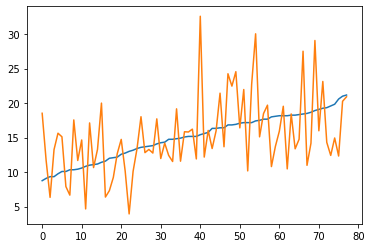

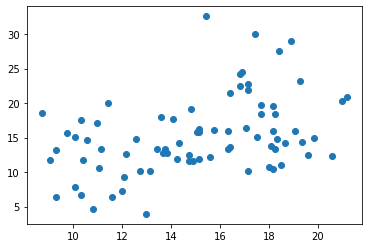

In [175]:
import matplotlib.pyplot as plt

# Ae = torch.einsum('nis,njs->nij',rest_ts_t_train,rest_ts_t_train)
# A = Ae.reshape(600,-1)
# w,_,_,_ = torch.linalg.lstsq(A,ages_train)

# Be = torch.einsum('nis,njs->nij',rest_ts_t_test,rest_ts_t_test)
# B = Be.reshape(78,-1)
# pred = B@w

pred = gat(rest_ts_t_test)
pred = pred.flatten().detach().cpu().numpy()
y = ages_test.detach().cpu().numpy()

idcs = np.argsort(y)
pred = pred[idcs]
y = y[idcs]

corr = np.corrcoef(y, pred)
rmse = np.mean((y-pred)**2)**0.5
mae = np.mean(np.abs(y-pred))

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(pred, label='Prediction')
plt.show()

plt.scatter(y, pred)
plt.show()

In [126]:
print(gat.fc.weight)

Parameter containing:
tensor([[ 0.0043, -0.0048, -0.0053,  ...,  0.0200,  0.0212,  0.0158]],
       device='cuda:0', requires_grad=True)


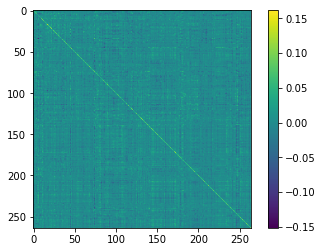

In [170]:
plt.imshow(gat.W[0].detach().cpu().numpy())
plt.colorbar()
plt.show()

In [173]:
print(gat.W[0][0,:])

tensor([ 8.0025e-02,  2.8012e-02,  2.1604e-02,  6.3236e-02,  4.8883e-02,
        -2.0184e-02,  4.7723e-02, -9.3262e-03,  1.6386e-05,  4.1808e-03,
        -3.9323e-02,  2.5366e-02,  2.0941e-02, -3.5513e-02, -1.6017e-02,
        -3.8196e-03,  2.6458e-05, -2.4361e-03, -1.8011e-02,  3.1628e-03,
         1.4514e-02, -5.1571e-03,  2.1075e-03,  2.6434e-05, -1.0814e-02,
        -3.4685e-03,  1.0113e-02, -2.4404e-02,  2.4454e-05,  1.6129e-05,
        -2.1978e-02, -8.1100e-04, -1.2526e-02, -9.5096e-04, -1.2715e-02,
         1.2044e-04,  9.9705e-03, -1.3437e-03,  2.4974e-05, -1.8137e-03,
        -4.0774e-07, -7.3438e-03, -1.8154e-02, -2.3141e-03, -5.2734e-03,
         6.4806e-03,  1.8413e-02,  9.9764e-04, -2.8555e-04,  1.3976e-02,
         4.8674e-03, -3.4420e-03, -9.7018e-04,  1.1969e-02, -5.7034e-03,
         2.4142e-03, -4.4477e-03,  1.7406e-06, -8.5715e-04, -4.9955e-03,
        -3.0055e-02,  2.5065e-03, -9.8543e-03, -6.4143e-03, -3.6409e-03,
        -4.6995e-04, -2.8001e-03, -3.4549e-03,  5.7